# Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from numpy import mean

# BERT

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertPreTrainedModel, BertModel, BertConfig, BertTokenizer

In [ ]:
model = BertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states = True,)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
def bert_text_preparation(text, slot_labels, tokenizer):
  just_check = []
  tokenized_text = []
  slot_labels_ids = []
  special_token_label_id = -1
  O_id = 0
  pad_token_id = tokenizer.pad_token_id
  marked_text = ['[CLS]'] + text + ['[SEP]']
  slot_labels = [special_token_label_id] + slot_labels + [special_token_label_id]
  max_seq_len = 37

  for word, slot_label in zip(marked_text, slot_labels):
    # print(word)
    # print(slot_label)
    word_tokens = tokenizer.tokenize(word)
    # print(word_tokens)
    if not word_tokens:
        word_tokens = [special_token_label_id]  # For handling the bad-encoded word
    tokenized_text.extend(word_tokens)
    # Use the real label id for the first token of the word, and padding ids for the remaining tokens
    first_label = int(slot_label)
    if first_label == 0: #O
      other_labels = 0
    elif first_label%2 == 1: #Odd numbers: B-
      other_labels = first_label + 1
    else:
      other_labels = first_label

    slot_labels_ids.extend([first_label] + [other_labels] * (len(word_tokens) - 1))

  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  attention_mask = [1]*len(indexed_tokens)

  padding_length = max_seq_len - len(indexed_tokens)
  indexed_tokens = indexed_tokens + ([pad_token_id] * padding_length)

  just_check.append(len(indexed_tokens))

  attention_mask = attention_mask + [0]*padding_length
  slot_labels_ids = slot_labels_ids + ([special_token_label_id] * padding_length)

  ### truncation
  indexed_tokens = indexed_tokens[:max_seq_len]
  attention_mask = attention_mask[:max_seq_len]
  slot_labels_ids = slot_labels_ids[:max_seq_len]

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([attention_mask])

  return tokens_tensor, segments_tensors, slot_labels_ids

In [ ]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):

  # Gradient calculation id disabled
  # Model is in inference mode
  with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      # Removing the first hidden state
      # The first state is the input state
      hidden_states = outputs[2][1:]

  # Getting embeddings from the final BERT layer
  token_embeddings = hidden_states[-1]

  return token_embeddings

In [ ]:
def get_embeddings(in_hand_data, in_hand_labels):
  list_emb = []
  list_attention = []
  list_slot_labels_ids = []
  for i in range(len(in_hand_data)):
    tokens_tensor, segments_tensors, slot_labels_ids = bert_text_preparation(in_hand_data[i], in_hand_labels[i], tokenizer)
    list_slot_labels_ids.append(slot_labels_ids)
    token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    # print(token_embeddings.size())
    list_emb.append(token_embeddings)
    list_attention.append(segments_tensors[0])
  return list_attention, list_emb, list_slot_labels_ids

# Discriminator class

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.disc = nn.Sequential(
          nn.Linear(in_features, 256),
          nn.Tanh(),
          nn.Linear(256, 128),
          nn.Sigmoid(),
          nn.Linear(128, 1), #nclass: 1
          nn.Sigmoid()
          # nn.Linear(in_features, 1),
          # nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

# Generator class

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_features, hidden_size, num_layers): #in_feautures: img_dim
    super(Generator, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gen = nn.LSTM(in_features, hidden_size, num_layers, batch_first = True, bidirectional=True)

  def forward(self, x):

    h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)).to(device)
    c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)).to(device)

    out, _ = self.gen(x, (h0, c0))
    # h_out = h_out.view(-1, self.hidden_size)

    return out

# Slot Tagger & IntentClassifier

In [ ]:
class LSTMTagger(nn.Module):
  def __init__(self, in_features, hidden_size, num_layers, tagset_size): #in_feautures: img_dim #, tagset_size
    super(LSTMTagger, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.tagset_size = tagset_size

    self.lstm = nn.LSTM(in_features, hidden_size, num_layers, batch_first = True, bidirectional=True)
    self.hidden2tag = nn.Linear(hidden_size*2, tagset_size)

  def forward(self, x):

    h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)).to(device)
    c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)).to(device)

    out, _ = self.lstm(x, (h0, c0))
    tag_space = self.hidden2tag(out)
    tag_scores = F.log_softmax(tag_space, dim=1)

    return tag_scores

In [ ]:
class IntentClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(512, 64)
    self.l2 = nn.Linear(64, 64)
    self.l3 = nn.Linear(64, 12) #number of intents: 12
    self.do = nn.Dropout(0.1)

  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    do = self.do(h2 + h1)
    logits = self.l3(do)
    return logits

# Hyperparameters

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
in_dim_D = 512
in_dim_G = 768
# half_batch = 16
# batch_size = 32
lambda_coef = 0.1 #Coefficient of loss_disc
WI = 15 #Number of warm-up iterations
hidden_size = 256
num_layers = 2

gen_ = Generator(in_dim_G, hidden_size, num_layers).to(device)
disc_ = Discriminator(in_dim_D).to(device)

opt_disc = optim.Adam(disc_.parameters(), lr=lr)
opt_gen = optim.Adam(gen_.parameters(), lr=lr)

criterion = nn.BCELoss()

In [ ]:
# Slot Filling
in_features = 512 #768
tagset_size = len(slot_dict) + 1
slot_tagger = LSTMTagger(in_features, hidden_size, num_layers, tagset_size).to(device)
loss_sf = nn.CrossEntropyLoss(ignore_index=-1)
opt_sf = optim.SGD(slot_tagger.parameters(), lr=0.1)

In [ ]:
# Intent Detection (ID)
classifier = IntentClassifier().to(device)
params_id = classifier.parameters()
loss_id = nn.CrossEntropyLoss(ignore_index=-1)
opt_id = optim.SGD(params_id, lr=1e-2)

# Main (training)

## warm-up iterations

In [ ]:
def extract_cls(L): #L: the output of Generator
  x_cls = [L[i][0] for i in range(len(L))]
  final_x = torch.stack(x_cls, dim=0)
  return final_x

In [ ]:
# WI = 75
for j in range(WI):

  loss_WI = []
  slot_tagger.train()
  classifier.train()
  gen_.train()

  for batch in eval_en_loader:#eval_en_loader
    x, y, z = batch
    x = x.to(device)
    # print('1: ', x.size())
    y = y.to(device)
    z = z.unsqueeze(1).to(device)

    g_x = gen_(x)
    sf_x = slot_tagger(g_x)

    xx = extract_cls(x)
    # print('2: ', xx.size())
    xx = xx.unsqueeze(1).to(device)
    # print('3: ', xx.size())
    g_xx = gen_(xx)
    id_x = classifier(g_xx)

    l_sf = torch.transpose(sf_x, 1, 2)
    l_id = torch.transpose(id_x, 1, 2)

    slot_tagger.zero_grad()
    classifier.zero_grad()
    gen_.zero_grad()

    J_sf = loss_sf(l_sf, y)
    J_id = loss_id(l_id, z)
    J = 0.5*(J_sf + J_id)

    J.backward()
    # print(J.item())
    opt_sf.step()
    opt_id.step()
    opt_gen.step()

    loss_WI.append(J.item())

  print(torch.tensor(loss_WI).mean())

In [ ]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(5, 5))
plt.plot(L, "-b", label="joint loss")
plt.legend(loc="center right")
plt.xlabel("epoch")  # Add x-axis label
# plt.ylabel("Y-axis Label")
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
ax.xaxis.set_major_locator(MultipleLocator(base=3))
plt.savefig('loss1.jpeg', dpi=2500, bbox_inches='tight')
plt.show()

## Adversarial Training

In [ ]:
num_epochs = 60; k_steps=3
alpha = 0.5; beta = 0.5

In [ ]:
L1, L2, L3, L4 = [], [], [], []
L1_e, L2_e, L3_e, L4_e = [], [], [], []

for epoch in range(num_epochs):

  gen_.train()
  disc_.train()
  slot_tagger.train()
  classifier.train()

  loss_T = []; loss_SF = []; loss_ID = []; loss_D = []
  i=0
  for batch_en, batch_aux in zip(train_en_loader, train_aux_loader):

      if i<k_steps:

        x_en, y_en, z_en = batch_en
        x_en = x_en.to(device)
        y_en = y_en.to(device)
        # z_en = z_en.to(device)

        x_aux, y_aux, z_aux = batch_aux
        x_aux = x_aux.to(device)
        y_aux = y_aux.to(device)
        # z_aux = z_aux.to(device)

        data_gen_en = gen_(x_en)

        data_gen_aux = gen_(x_aux)

        disc_gen_en = disc_(data_gen_en)
        disc_gen_aux = disc_(data_gen_aux)

        disc_.zero_grad()

        loss_disc_real = criterion(disc_gen_en, torch.ones_like(disc_gen_en))
        loss_disc_fake = criterion(disc_gen_aux, torch.zeros_like(disc_gen_en))
        loss_disc = 0.5*(loss_disc_real + loss_disc_fake)

        loss_disc.backward(retain_graph=True)

        opt_disc.step()
        i = i + 1
        # print(i)
      else:

        x_en_t, y_en_t, z_en_t = batch_en
        x_en_t = x_en_t.to(device) #data
        y_en_t = y_en_t.to(device) #SF
        z_en_t = z_en_t.unsqueeze(1).to(device) #ID

        x_aux_t, y_aux_t, z_aux_t = batch_aux
        x_aux_t = x_aux_t.to(device)
        y_aux_t = y_aux_t.to(device)
        # z_aux_t = z_aux_t.to(device)

        data_gen_en_t = gen_(x_en_t)

        data_gen_aux_t = gen_(x_aux_t)

        disc_gen_en_t = disc_(data_gen_en_t)
        disc_gen_aux_t = disc_(data_gen_aux_t)

        slot_gen_en_t = slot_tagger(data_gen_en_t)
        ###
        xx_en_t = extract_cls(x_en_t)
        xx_en_t = xx_en_t.unsqueeze(1)
        g_xx = gen_(xx_en_t)
        ###
        id_gen_en_t = classifier(g_xx)
        ###

        gen_.zero_grad()
        # slot_tagger.zero_grad()
        # classifier.zero_grad()

        loss_disc_real_t= criterion(disc_gen_en_t, torch.ones_like(disc_gen_en_t))
        loss_disc_fake_t = criterion(disc_gen_aux_t, torch.zeros_like(disc_gen_aux_t))
        loss_disc_t = 0.5*(loss_disc_real_t + loss_disc_fake_t)
        loss_D.append(loss_disc_t.item())

        l_sf_en = torch.transpose(slot_gen_en_t, 1, 2)
        l_sf_en_t = loss_sf(l_sf_en, y_en_t)
        loss_SF.append(l_sf_en_t.item())

        l_id_en = torch.transpose(id_gen_en_t, 1, 2)
        l_id_en_t = loss_id(l_id_en, z_en_t)
        loss_ID.append(l_id_en_t.item())

        # loss_total_1 = l_sf_en_t - lambda_coef * loss_disc_t
        # loss_total_2 = l_id_en_t - lambda_coef * loss_disc_t
        # loss_total = 0.5 *(loss_total_1 + loss_total_2)
        loss_total = alpha*l_sf_en_t + beta*l_id_en_t - lambda_coef * loss_disc_t

        loss_T.append(loss_total.item())
        #print(l_sf_en_t)
        loss_total.backward()

        opt_gen.step() #only step() for the optimizer of the shared layer
        # opt_sf.step()
        # opt_id.step()
        #########################################################################################################################
        ### for updating SF and ID modules, each with its own loss
        x_en_t_2, y_en_t_2, z_en_t_2 = batch_en
        x_en_t_2 = x_en_t_2.to(device) #data
        y_en_t_2 = y_en_t_2.to(device) #SF
        z_en_t_2 = z_en_t_2.unsqueeze(1).to(device) #ID

        x_aux_t_2, y_aux_t_2, z_aux_t_2 = batch_aux
        x_aux_t_2 = x_aux_t_2.to(device)
        y_aux_t_2 = y_aux_t_2.to(device)

        data_gen_en_t_2 = gen_(x_en_t_2)

        data_gen_aux_t_2= gen_(x_aux_t_2)

        disc_gen_en_t_2= disc_(data_gen_en_t_2)
        # disc_gen_aux_t_2= disc_(data_gen_aux_t_2)

        slot_gen_en_t_2= slot_tagger(data_gen_en_t_2)
        ###
        xx_en_t_2= extract_cls(x_en_t_2)
        xx_en_t_2= xx_en_t_2.unsqueeze(1)
        g_xx_2 = gen_(xx_en_t_2)
        ###
        id_gen_en_t_2= classifier(g_xx_2)
        ###

        slot_tagger.zero_grad()
        classifier.zero_grad()

        l_sf_en_2 = torch.transpose(slot_gen_en_t_2, 1, 2)
        l_sf_en_t_2= loss_sf(l_sf_en_2, y_en_t_2)
        # loss_SF.append(l_sf_en_t.item())

        l_id_en_2 = torch.transpose(id_gen_en_t_2, 1, 2)
        l_id_en_t_2 = loss_id(l_id_en_2, z_en_t_2)

        # J = 0.5*(l_sf_en_t_2 + l_id_en_t_2)
        # J.backward()

        l_id_en_t_2.backward()
        opt_id.step()

        l_sf_en_t_2.backward()
        opt_sf.step()

        #########################################################################################################################
        i=0

  loss_T_per_epoch = mean(loss_T); L1.append(loss_T_per_epoch)
  loss_SF_per_epoch = mean(loss_SF); L2.append(loss_SF_per_epoch)
  loss_ID_per_epoch = mean(loss_ID); L3.append(loss_ID_per_epoch)
  loss_D_per_epoch = mean(loss_D); L4.append(loss_D_per_epoch)

  print(f'Epoch {epoch}, \
  train_loss_total:{loss_T_per_epoch: .5f}, train_loss_SF:{loss_SF_per_epoch: .5f}, train_loss_ID:{loss_ID_per_epoch: .5f},\
  train_loss_disc:{loss_D_per_epoch: .5f}')

  #### Validation #####
  gen_.eval()
  disc_.eval()
  slot_tagger.eval()
  classifier.eval()

  loss_T_eval = []; loss_SF_eval =[]; loss_ID_eval =[]; loss_D_eval = []

  for batch_en, batch_aux in zip(eval_en_loader, eval_aux_loader):

    x_en, y_en, z_en = batch_en
    x_en = x_en.to(device)
    y_en = y_en.to(device)
    z_en = z_en.unsqueeze(1).to(device)

    x_aux, y_aux, z_aux = batch_aux
    x_aux = x_aux.to(device)
    y_aux = y_aux.to(device)
    # z_aux = z_aux.to(device)

    with torch.no_grad():

      data_gen_en_e = gen_(x_en)
      data_gen_aux_e = gen_(x_aux)

      disc_gen_en_e = disc_(data_gen_en_e)
      disc_gen_aux_e = disc_(data_gen_aux_e)

      slot_gen_en_e = slot_tagger(data_gen_en_e)
      ###
      xx_en_e = extract_cls(x_en)
      xx_en_e = xx_en_e.unsqueeze(1)
      g_xx_en_e = gen_(xx_en_e)
      ###
      id_gen_en_e = classifier(g_xx_en_e)

    loss_disc_real_e = criterion(disc_gen_en_e, torch.ones_like(disc_gen_en_e))
    loss_disc_fake_e = criterion(disc_gen_aux_e, torch.zeros_like(disc_gen_aux_e))
    loss_disc_eval = 0.5*(loss_disc_real + loss_disc_fake)
    loss_D_eval.append(loss_disc_eval.item())

    l_sf_en_e = torch.transpose(slot_gen_en_e, 1, 2)
    l_sf_en_eval = loss_sf(l_sf_en_e, y_en)
    loss_SF_eval.append(l_sf_en_eval.item())

    l_id_en_e = torch.transpose(id_gen_en_e, 1, 2)
    l_id_en_eval = loss_id(l_id_en_e, z_en)
    loss_ID_eval.append(l_id_en_eval.item())

    # loss_total_eval_1 = l_sf_en_eval - lambda_coef * loss_disc_eval
    # loss_total_eval_2 = l_id_en_eval - lambda_coef * loss_disc_eval
    # loss_total_eval = 0.5 * (loss_total_eval_1 + loss_total_eval_2)
    loss_total_eval = alpha*l_sf_en_eval + beta*l_id_en_eval - lambda_coef * loss_disc_eval

    loss_T_eval.append(loss_total_eval.item())

  loss_T_per_epoch_e = mean(loss_T_eval); L1_e.append(loss_T_per_epoch_e)
  loss_SF_per_epoch_e = mean(loss_SF_eval); L2_e.append(loss_SF_per_epoch_e)
  loss_ID_per_epoch_e = mean(loss_ID_eval); L3_e.append(loss_ID_per_epoch_e)
  loss_D_per_epoch_e = mean(loss_D_eval); L4_e.append(loss_D_per_epoch_e)

  print(f'Epoch {epoch}, \
  eval_loss_total:{loss_T_per_epoch_e: .5f}, eval_loss_SF:{loss_SF_per_epoch_e: .5f}, eval_loss_ID:{loss_ID_per_epoch_e: .5f},\
  eval_loss_disc:{loss_D_per_epoch_e: .5f}')
  print('*****')

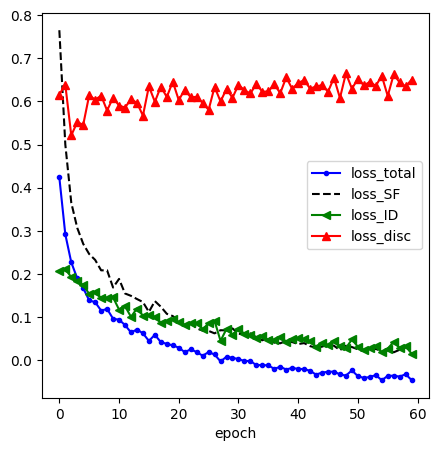

In [ ]:
# from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(5, 5))
plt.plot(L1, ".-b", label="loss_total")
plt.plot(L2, "--k", label="loss_SF")
plt.plot(L3, "-<g", label="loss_ID")
plt.plot(L4, "-^r", label="loss_disc")
ax = plt.gca()
# ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
ax.xaxis.set_major_locator(MultipleLocator(base=10))
plt.xlabel("epoch")  # Add x-axis label
plt.legend(loc="center right")
# plt.subplots_adjust(right=0.8, top=0.9)
# plt.legend(loc="upper right")
plt.savefig('loss2.jpeg', dpi=4000, bbox_inches='tight')
plt.show()